Importing the necessary libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
sb.set()

In [2]:
choc = pd.read_csv('cleaned_chocolate.csv')

# One-hot encoding for categorical variables

In [3]:
# one hot encoding
choc_ohe = choc[['country_of_bean_origin',
                 'first_taste', 'second_taste', 'third_taste', 'fourth_taste']]
choc_ohe = pd.get_dummies(data = choc_ohe)

# extracting rest of the predictors
choc_num = choc[['cocoa_percent', 'counts_of_ingredients', 'number_of_taste']]
                 #'cocoa_butter', 'vanilla', 'lecithin', 'salt', 'sugar', 'sweetener_without_sugar']]

# extracting response
choc_response = choc['rating_category']

# combining predictors and response
choc_ohe = pd.concat([choc_ohe, choc_response, choc_num], sort = False, axis = 1)
choc_ohe

,country_of_bean_origin_Australia,country_of_bean_origin_Belize,country_of_bean_origin_Blend,country_of_bean_origin_Bolivia,country_of_bean_origin_Bolvia,country_of_bean_origin_Brazil,country_of_bean_origin_Burma,country_of_bean_origin_Cameroon,country_of_bean_origin_Colombia,country_of_bean_origin_Congo,...,fourth_taste_tang,fourth_taste_tart,fourth_taste_vanilla,fourth_taste_vegetal,fourth_taste_wine,fourth_taste_woody,rating_category,cocoa_percent,counts_of_ingredients,number_of_taste
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,76.0,3,3
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,76.0,3,3
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,76.0,3,3
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,63.0,4,3
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,70.0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2219,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,80.0,4,3
2220,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,75.0,3,2
2221,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,72.0,3,3
2222,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,70.0,3,3


For our models, we are going to use Stratified K Fold cross validation to evaluate the model, as well as calculating its accuracy rate on a training and testing data set

In [6]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

Extract response and predictor variables, and split train and test set

In [8]:
y1 = pd.DataFrame(choc_ohe['rating_category'])
X1 = pd.DataFrame(choc_ohe.drop('rating_category', axis = 1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, stratify = y1)

# Classification tree

We start off with a very simple model, a decision tree classifier

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Extract Response and Predictors

In [9]:
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

Using stratified K fold cross validation to evaluate the model

In [24]:
dectree = DecisionTreeClassifier(max_depth = 40) #Give good parameters
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_validate(dectree, X1, y1, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')
#print(n_scores)
print('accuracy: %.3f (%.3f)' % (np.mean(n_scores["test_accuracy"]), np.std(n_scores["test_accuracy"])))
print('precison: %.3f (%.3f)' % (np.mean(n_scores["test_precision"]), np.std(n_scores["test_precision"])))
print('recall: %.3f (%.3f)' % (np.mean(n_scores["test_recall"]), np.std(n_scores["test_recall"])))
print('f1 score: %.3f (%.3f)' % (np.mean(n_scores["test_f1_score"]), np.std(n_scores["test_f1_score"])))

accuracy: 0.613 (0.027)
precison: 0.641 (0.022)
recall: 0.708 (0.044)
f1 score: 0.672 (0.027)


Test the model on a train and test data set

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.9302979201798763

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.597752808988764

True '1' rate Train :	 0.975975975975976
True '0' rate Train :	 0.8717948717948718

False '1' rate Train :	 0.1282051282051282
False '0' rate Train :	 0.024024024024024024

True '1' rate Test :	 0.632
True '0' rate Test :	 0.5538461538461539

False '1' rate Test :	 0.4461538461538462
False '0' rate Test :	 0.368



<AxesSubplot:>

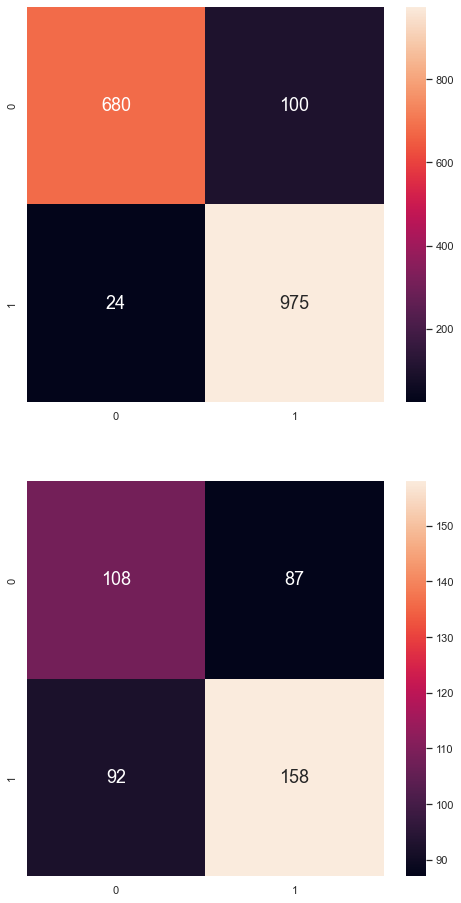

In [25]:
dectree.fit(X1_train, y1_train)                     # train the decision tree model

# Predict Response corresponding to Predictors
y1_train_pred = dectree.predict(X1_train)
y1_test_pred = dectree.predict(X1_test)

# Check the Goodness of Fit on Train Data
print("Goodness of Fit of Model \tTrain Dataset")
print("Classification Accuracy \t:", dectree.score(X1_train, y1_train))
print()

# Check the Goodness of Fit on Test Data
print("Goodness of Fit of Model \tTest Dataset")
print("Classification Accuracy \t:", dectree.score(X1_test, y1_test))
print()

trainData = confusion_matrix(y1_train, y1_train_pred)
testData = confusion_matrix(y1_test, y1_test_pred)


print("True '1' rate Train :\t", (trainData[1][1]/(trainData[1][0]+trainData[1][1])))
print("True '0' rate Train :\t", (trainData[0][0]/(trainData[0][0]+trainData[0][1])))
print()

print("False '1' rate Train :\t", ((trainData[0][1])/((trainData[0][1]+trainData[0][0]))))
print("False '0' rate Train :\t", ((trainData[1][0])/((trainData[1][0]+trainData[1][1]))))
print()

print("True '1' rate Test :\t", (testData[1][1]/(testData[1][0]+testData[1][1])))
print("True '0' rate Test :\t", (testData[0][0]/(testData[0][0]+testData[0][1])))
print()

print("False '1' rate Test :\t", ((testData[0][1])/((testData[0][1]+testData[0][0]))))
print("False '0' rate Test :\t", ((testData[1][0])/((testData[1][0]+testData[1][1]))))
print()

# Plot the Confusion Matrix for Train and Test
f, axes = plt.subplots(2, 1, figsize=(8, 16))
sb.heatmap(trainData,
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(testData, 
           annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])

Overall, the Classification Tree model did quite a bad job of predicting our chocolate rating, let's see how we can improve upon that accuracy.

# Random Forest

Importing the libraries

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [27]:
# Extract Response and Predictors
y = pd.DataFrame(choc_ohe['rating_category'])
X = pd.DataFrame(choc_ohe.drop('rating_category', axis = 1))

Using stratified K fold cross validation to evaluate the model

In [32]:
rforest = RandomForestClassifier(n_estimators = 600, max_depth = 80)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
n_scores = cross_validate(rforest, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')
#print(n_scores)
print('accuracy: %.3f (%.3f)' % (np.mean(n_scores["test_accuracy"]), np.std(n_scores["test_accuracy"])))
print('precison: %.3f (%.3f)' % (np.mean(n_scores["test_precision"]), np.std(n_scores["test_precision"])))
print('recall: %.3f (%.3f)' % (np.mean(n_scores["test_recall"]), np.std(n_scores["test_recall"])))
print('f1 score: %.3f (%.3f)' % (np.mean(n_scores["test_f1_score"]), np.std(n_scores["test_f1_score"])))

accuracy: 0.681 (0.022)
precison: 0.677 (0.015)
recall: 0.826 (0.031)
f1 score: 0.744 (0.020)


Test the model on a train and test data set

Train Data
Accuracy  :	 0.9938167509836987

Test Data
Accuracy  :	 0.6808988764044944

True '1' rate Train :	 1.0
True '0' rate Train :	 0.985897435897436

False '1' rate Train :	 0.014102564102564103
False '0' rate Train :	 0.0

True '1' rate Test :	 0.808
True '0' rate Test :	 0.517948717948718

False '1' rate Test :	 0.48205128205128206
False '0' rate Test :	 0.192



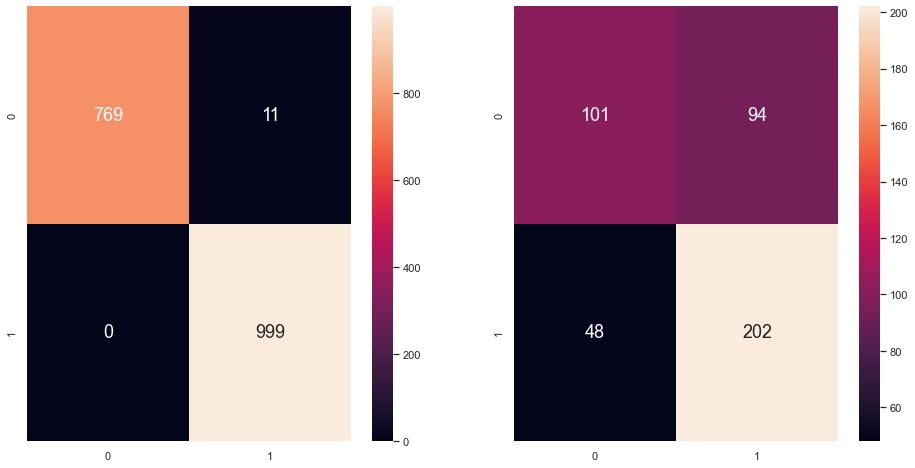

In [33]:
# Split the Dataset into Train and Test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Fit Random Forest on Train Data
rforest.fit(X1_train, y1_train.rating_category.ravel())

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X1_train, y1_train))
print()

print("Test Data")
print("Accuracy  :\t", rforest.score(X1_test, y1_test))
print()

# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X1_train)
y_test_pred = rforest.predict(X1_test)

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y1_train, y_train_pred)
cmTest = confusion_matrix(y1_test, y_test_pred)

print("True '1' rate Train :\t", (cmTrain[1][1]/(cmTrain[1][0]+cmTrain[1][1])))
print("True '0' rate Train :\t", (cmTrain[0][0]/(cmTrain[0][0]+cmTrain[0][1])))
print()


print("False '1' rate Train :\t", ((cmTrain[0][1])/((cmTrain[0][1]+cmTrain[0][0]))))
print("False '0' rate Train :\t", ((cmTrain[1][0])/((cmTrain[1][0]+cmTrain[1][1]))))
print()


print("True '1' rate Test :\t", (cmTest[1][1]/(cmTest[1][0]+cmTest[1][1])))
print("True '0' rate Test :\t", (cmTest[0][0]/(cmTest[0][0]+cmTest[0][1])))
print()

print("False '1' rate Test :\t", ((cmTest[0][1])/((+cmTest[0][1]+cmTest[0][0]))))
print("False '0' rate Test :\t", ((cmTest[1][0])/((cmTest[1][0]+cmTest[1][1]))))
print()

# Plot the Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(16, 8))
sb.heatmap(cmTrain, annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(cmTest, annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
plt.show()

We have good accuracy on the training data set, but horrible accuracy on the test dataset, this might be a case of overfitting.
We predict too much '0' value as '1', which can mess with our prediction of a highly rated chocolate bar

# Upsampling the minority classes

In [34]:
# See which category of rating is imbalanced
choc_ohe.rating_category.value_counts()

1    1249
0     975
Name: rating_category, dtype: int64

In [37]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [39]:
# Extract Response and Predictors
y = pd.DataFrame(choc_ohe['rating_category'])
X = pd.DataFrame(choc_ohe.drop('rating_category', axis = 1))

In [41]:
rforest = RandomForestClassifier(n_estimators = 1000, max_depth = 80)
sm = SMOTE()
steps = [("smote", sm), ("model", rforest)]
pipeline = Pipeline(steps = steps)

Using stratified K fold cross validation to evalute the model

In [44]:

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1, error_score='raise')
print('accuracy: %.3f (%.3f)' % (np.mean(n_scores["test_accuracy"]), np.std(n_scores["test_accuracy"])))
print('precison: %.3f (%.3f)' % (np.mean(n_scores["test_precision"]), np.std(n_scores["test_precision"])))
print('recall: %.3f (%.3f)' % (np.mean(n_scores["test_recall"]), np.std(n_scores["test_recall"])))
print('f1 score: %.3f (%.3f)' % (np.mean(n_scores["test_f1_score"]), np.std(n_scores["test_f1_score"])))

accuracy: 0.639 (0.030)
precison: 0.747 (0.036)
recall: 0.540 (0.045)
f1 score: 0.626 (0.037)


Test the model on a train and test data set

In [46]:
X1_train_res, y1_train_res = sm.fit_resample(X1_train, y1_train)

In [ ]:
# Split the Dataset into Train and Test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Fit Random Forest on Train Data
rforest.fit(X1_train_res, y1_train_res.rating_category.ravel())

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X1_train_res, y1_train_res))
print()
print("Test Data")
print("Accuracy  :\t", rforest.score(X1_test, y1_test))
print()

# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X1_train_res)
y_test_pred = rforest.predict(X1_test_res)

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
cmTest = confusion_matrix(y_test, y_test_pred)

print("True '1' rate Train :\t", (cmTrain[1][1]/(cmTrain[1][0]+cmTrain[1][1])))
print("True '0' rate Train :\t", (cmTrain[0][0]/(cmTrain[0][0]+cmTrain[0][1])))
print()

print("False '1' rate Train :\t", ((cmTrain[0][1])/((cmTrain[2][1]+cmTrain[0][1]+cmTrain[2][2]+cmTrain[0][2]+cmTrain[2][0]+cmTrain[0][0]))))
print("False '0' rate Train :\t", ((cmTrain[1][0]+cmTrain[2][0])/((cmTrain[1][0]+cmTrain[2][0]+cmTrain[1][1]+cmTrain[2][1]+cmTrain[1][2]+cmTrain[2][2]))))
print()

print("True '1' rate Test :\t", (cmTest[1][1]/(cmTest[1][0]+cmTest[1][1]+cmTest[1][2])))
print("True '0' rate Test :\t", (cmTest[0][0]/(cmTest[0][0]+cmTest[0][1]+cmTest[0][2])))
print()

print("False '1' rate Test :\t", ((cmTest[2][1]+cmTest[0][1])/((cmTest[2][1]+cmTest[0][1]+cmTest[2][2]+cmTest[0][2]+cmTest[2][0]+cmTest[0][0]))))
print("False '0' rate Test :\t", ((cmTest[1][0]+cmTest[2][0])/((cmTest[1][0]+cmTest[2][0]+cmTest[1][1]+cmTest[2][1]+cmTest[1][2]+cmTest[2][2]))))
print()

# Plot the Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(16, 8))
sb.heatmap(cmTrain, annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(cmTest, annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
plt.show()

Much better accuracy, and less bias towards the training dataset

# Removing minority classes

In the columns "country_of_bean_origin", there are a lot of data which only appeared 2 or 3 times.

In [ ]:
choc_xoutlier = choc[choc["country_of_bean_origin"].isin(beanOriginTop["index"])]
choc_xoutlier

In [ ]:
# one hot encoding
choc_xoutlier_ohe = choc_xoutlier[['country_of_bean_origin',
                                   'first_taste', 'second_taste', 'third_taste', 'fourth_taste']]
choc_xoutlier_ohe = pd.get_dummies(data = choc_xoutlier_ohe)

# extracting rest of the predictors
choc_xoutlier_num = choc_xoutlier[['cocoa_percent', 'counts_of_ingredients', 'number_of_taste']]
                                   #'cocoa_butter', 'vanilla', 'lecithin', 'salt', 'sugar', 'sweetener_without_sugar']]

# extracting response
choc_xoutlier_response = choc_xoutlier['rating_category']

#combining predictors and response
choc_xoutlier_ohe = pd.concat([choc_xoutlier_ohe, choc_xoutlier_response, choc_xoutlier_num], sort = False, axis = 1)
choc_xoutlier_ohe

In [ ]:
choc_xoutlier_ohe.rating_category.value_counts()

In [ ]:
# Upsample rating_category
rating0 = choc_xoutlier_ohe[choc_xoutlier_ohe.rating_category == '0']
rating1 = choc_xoutlier_ohe[choc_xoutlier_ohe.rating_category == '1']
rating2 = choc_xoutlier_ohe[choc_xoutlier_ohe.rating_category == '2']
 
# Upsampling 0 and 1
rating0_up = resample(rating0,
                      replace=True,                  # sample with replacement
                      n_samples=rating2.shape[0])    # to match number '2'

rating1_up = resample(rating1,
                      replace=True,                  # sample with replacement
                      n_samples=rating2.shape[0])    # to match number '2'
 
# Combine the three classes back after upsampling
choc_xoutlier_ohe_up = pd.concat([rating2, rating0_up, rating1_up])
 
# Check the ratio of the classes
choc_xoutlier_ohe_up['rating_category'].value_counts()

In [ ]:
# Extract Response and Predictors
y = pd.DataFrame(choc_xoutlier_ohe_up['rating_category'])
X = pd.DataFrame(choc_xoutlier_ohe_up.drop('rating_category', axis = 1))

Using stratified K fold cross validation to evalute the model

In [ ]:
rforest = RandomForestClassifier(n_estimators = 800, max_depth = 80)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(rforest, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Test the model on a train and test data set

In [ ]:
# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Fit Random Forest on Train Data
rforest.fit(X_train, y_train.rating_category.ravel())

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train, y_train))
print()
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test, y_test))
print()

# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train)
y_test_pred = rforest.predict(X_test)

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
cmTest = confusion_matrix(y_test, y_test_pred)

print("True '2' rate Train :\t", (cmTrain[2][2]/(cmTrain[2][0]+cmTrain[2][1]+cmTrain[2][2])))
print("True '1' rate Train :\t", (cmTrain[1][1]/(cmTrain[1][0]+cmTrain[1][1]+cmTrain[1][2])))
print("True '0' rate Train :\t", (cmTrain[0][0]/(cmTrain[0][0]+cmTrain[0][1]+cmTrain[0][2])))
print()

print("False '2' rate Train :\t", ((cmTrain[1][2]+cmTrain[0][2])/((cmTrain[1][2]+cmTrain[0][2]+cmTrain[1][1]+cmTrain[0][1]+cmTrain[1][0]+cmTrain[0][0]))))
print("False '1' rate Train :\t", ((cmTrain[2][1]+cmTrain[0][1])/((cmTrain[2][1]+cmTrain[0][1]+cmTrain[2][2]+cmTrain[0][2]+cmTrain[2][0]+cmTrain[0][0]))))
print("False '0' rate Train :\t", ((cmTrain[1][0]+cmTrain[2][0])/((cmTrain[1][0]+cmTrain[2][0]+cmTrain[1][1]+cmTrain[2][1]+cmTrain[1][2]+cmTrain[2][2]))))
print()

print("True '2' rate Test :\t", (cmTest[2][2]/(cmTest[2][0]+cmTest[2][1]+cmTest[2][2])))
print("True '1' rate Test :\t", (cmTest[1][1]/(cmTest[1][0]+cmTest[1][1]+cmTest[1][2])))
print("True '0' rate Test :\t", (cmTest[0][0]/(cmTest[0][0]+cmTest[0][1]+cmTest[0][2])))
print()

print("False '2' rate Test :\t", ((cmTest[1][2]+cmTest[0][2])/((cmTest[1][2]+cmTest[0][2]+cmTest[1][1]+cmTest[0][1]+cmTest[1][0]+cmTest[0][0]))))
print("False '1' rate Test :\t", ((cmTest[2][1]+cmTest[0][1])/((cmTest[2][1]+cmTest[0][1]+cmTest[2][2]+cmTest[0][2]+cmTest[2][0]+cmTest[0][0]))))
print("False '0' rate Test :\t", ((cmTest[1][0]+cmTest[2][0])/((cmTest[1][0]+cmTest[2][0]+cmTest[1][1]+cmTest[2][1]+cmTest[1][2]+cmTest[2][2]))))
print()

# Plot the Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(16, 8))
sb.heatmap(cmTrain, annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(cmTest, annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
plt.show()

To add comment here

# Gradient Boosting

Let's try a more sophisticated model, Gradient Boosting Machine

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
# gradient boosting for classification in scikit-learn

In [ ]:
y = pd.DataFrame(choc_xoutlier_ohe_up['rating_category'])
X = pd.DataFrame(choc_xoutlier_ohe_up.drop('rating_category', axis = 1))

Using stratified K fold cross validation to evalute the model

In [ ]:
GradBoost = GradientBoostingClassifier(loss = "deviance", learning_rate = 0.1, n_estimators = 500, subsample = 0.5, max_depth = 6) 
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(GradBoost, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Test the model on a train and test data set

In [ ]:
GradBoost.fit(X_train, y_train)
print("Train Data")
print("Accuracy  :\t", GradBoost.score(X_train, y_train))
print()
print("Test Data")
print("Accuracy  :\t", GradBoost.score(X_test, y_test))
print()
y_train_pred = GradBoost.predict(X_train)
y_test_pred = GradBoost.predict(X_test)

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
cmTest = confusion_matrix(y_test, y_test_pred)

print("True '2' rate Train :\t", (cmTrain[2][2]/(cmTrain[2][0]+cmTrain[2][1]+cmTrain[2][2])))
print("True '1' rate Train :\t", (cmTrain[1][1]/(cmTrain[1][0]+cmTrain[1][1]+cmTrain[1][2])))
print("True '0' rate Train :\t", (cmTrain[0][0]/(cmTrain[0][0]+cmTrain[0][1]+cmTrain[0][2])))
print()

print("False '2' rate Train :\t", ((cmTrain[1][2]+cmTrain[0][2])/((cmTrain[1][2]+cmTrain[0][2]+cmTrain[1][1]+cmTrain[0][1]+cmTrain[1][0]+cmTrain[0][0]))))
print("False '1' rate Train :\t", ((cmTrain[2][1]+cmTrain[0][1])/((cmTrain[2][1]+cmTrain[0][1]+cmTrain[2][2]+cmTrain[0][2]+cmTrain[2][0]+cmTrain[0][0]))))
print("False '0' rate Train :\t", ((cmTrain[1][0]+cmTrain[2][0])/((cmTrain[1][0]+cmTrain[2][0]+cmTrain[1][1]+cmTrain[2][1]+cmTrain[1][2]+cmTrain[2][2]))))
print()

print("True '2' rate Test :\t", (cmTest[2][2]/(cmTest[2][0]+cmTest[2][1]+cmTest[2][2])))
print("True '1' rate Test :\t", (cmTest[1][1]/(cmTest[1][0]+cmTest[1][1]+cmTest[1][2])))
print("True '0' rate Test :\t", (cmTest[0][0]/(cmTest[0][0]+cmTest[0][1]+cmTest[0][2])))
print()

print("False '2' rate Test :\t", ((cmTest[1][2]+cmTest[0][2])/((cmTest[1][2]+cmTest[0][2]+cmTest[1][1]+cmTest[0][1]+cmTest[1][0]+cmTest[0][0]))))
print("False '1' rate Test :\t", ((cmTest[2][1]+cmTest[0][1])/((cmTest[2][1]+cmTest[0][1]+cmTest[2][2]+cmTest[0][2]+cmTest[2][0]+cmTest[0][0]))))
print("False '0' rate Test :\t", ((cmTest[1][0]+cmTest[2][0])/((cmTest[1][0]+cmTest[2][0]+cmTest[1][1]+cmTest[2][1]+cmTest[1][2]+cmTest[2][2]))))
print()

# Plot the Confusion Matrix
f, axes = plt.subplots(1, 2, figsize=(16, 8))
sb.heatmap(cmTrain, annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
sb.heatmap(cmTest, annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])
plt.show()